<a href="https://colab.research.google.com/github/tienbuilam/Image-Depth-Estimation/blob/main/Module2_Image_Depth_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
!gdown --id 14gf8bcym_lTcvjZQmg8kwq3aXkENBxMQ
!gdown --id 1wxmiUdqMciuTOs0ouKEISl8-iTVXdOWn

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=14gf8bcym_lTcvjZQmg8kwq3aXkENBxMQ
To: /content/tsukuba.zip
100% 354k/354k [00:00<00:00, 84.0MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1wxmiUdqMciuTOs0ouKEISl8-iTVXdOWn
To: /content/Aloe_images.zip
100% 1.32M/1.32M [00:00<00:00, 149MB/s]


In [ ]:
!unzip /content/tsukuba.zip
!unzip /content/Aloe_images.zip

Archive:  /content/tsukuba.zip
mapname:  conversion of  failed
 extracting: left.png                
 extracting: right.png               
 extracting: groundtruth.png         
Archive:  /content/Aloe_images.zip
  inflating: Aloe/Aloe_left_1.png    
  inflating: Aloe/Aloe_right_3.png   
  inflating: Aloe/Aloe_right_1.png   
  inflating: Aloe/Aloe_right_2.png   
  inflating: Aloe/Disparity_map_corr.png  


#Problem 1


In [ ]:
def l1_distance(x, y):
    return abs(x - y)

In [ ]:
def l2_distance(x, y):
    return (x - y) ** 2

In [ ]:
def pixel_wise_matching_l1(left_img, right_img, disparity_range, save_result=True):
    # Read left, right images then convert to grayscale
    left = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]

    # Create blank disparity map
    depth = np.zeros((height, width), np.uint8)
    scale = 16
    max_value = 255

    for y in range(height):
        for x in range(width):
            disparity = 0
            cost_min = max_value

            for j in range(disparity_range):
                cost = max_value if (x - j) < 0 else l1_distance(int(left[y, x]), int(right[y, x - j]))

                if cost < cost_min:
                    cost_min = cost
                    disparity = j

            depth[y, x] = disparity * scale

    if save_result:
        print('Saving result...')
        cv2.imwrite('pixel_wise_l1.png', depth)
        cv2.imwrite('pixel_wise_l1_color.png', cv2.applyColorMap(depth, cv2.COLORMAP_JET))

    print('Done.')
    return depth

In [ ]:
def pixel_wise_matching_l2(left_img, right_img, disparity_range, save_result=True):
    # Read left, right images then convert to grayscale
    left = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]

    # Create blank disparity map
    depth = np.zeros((height, width), np.uint8)
    scale = 16
    max_value = 255**2

    for y in range(height):
        for x in range(width):
            disparity = 0
            cost_min = max_value

            for j in range(disparity_range):
                cost = max_value if (x - j) < 0 else l2_distance(int(left[y, x]), int(right[y, x - j]))

                if cost < cost_min:
                    cost_min = cost
                    disparity = j

            depth[y, x] = disparity * scale

    if save_result:
        print('Saving result...')
        cv2.imwrite('pixel_wise_l2.png', depth)
        cv2.imwrite('pixel_wise_l2_color.png', cv2.applyColorMap(depth, cv2.COLORMAP_JET))

    print('Done.')
    return depth

In [ ]:
left_img_path = '/content/left.png'
right_img_path = '/content/right.png'
disparity_range = 16

pixel_wise_result_l1 = pixel_wise_matching_l1(left_img_path, right_img_path, disparity_range, save_result = True)

pixel_wise_result_l2 = pixel_wise_matching_l2(left_img_path, right_img_path, disparity_range, save_result = True)

Saving result...
Done.
Saving result...
Done.


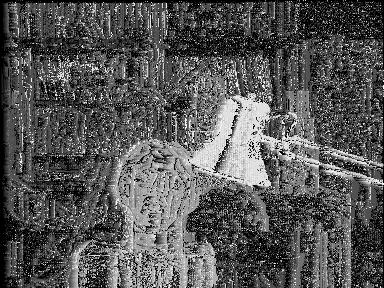

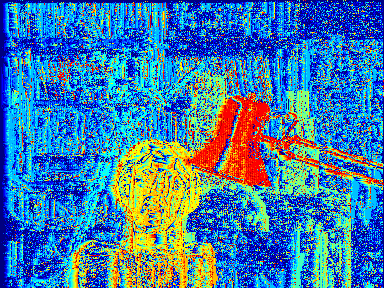

In [ ]:
cv2_imshow(pixel_wise_result_l1)

pixel_wise_l1_color = cv2.imread('pixel_wise_l1_color.png')
cv2_imshow(pixel_wise_l1_color)

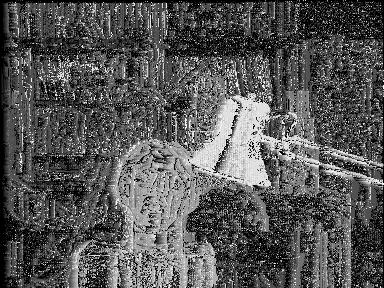

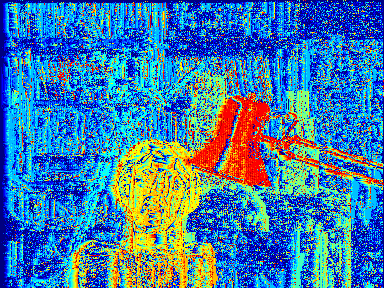

In [ ]:
cv2_imshow(pixel_wise_result_l2)

pixel_wise_l2_color = cv2.imread('pixel_wise_l2_color.png')
cv2_imshow(pixel_wise_l2_color)

#Problem 2

In [ ]:
def window_based_matching_l1(left_img, right_img, disparity_range, kernel_size=5, save_result=True):
    # Read left, right images then convert to grayscale
    left = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]

    # Create blank disparity map
    depth = np.zeros((height, width), np.uint8)

    kernel_half = int((kernel_size - 1) / 2)
    scale = 3
    max_value = 255 * 9

    for y in range(kernel_half, height - kernel_half + 1):
        for x in range(kernel_half, width - kernel_half + 1):

            disparity = 0
            cost_min = 65534

            for j in range(disparity_range):
                total = 0
                value = 0

                for v in range(-kernel_half, kernel_half):
                    for u in range(-kernel_half, kernel_half):
                        value = max_value
                        if (x + u - j) >= 0:
                            value = l1_distance(int(left[y + v, x + u]), int(right[y + v, (x + u) - j]))
                        total += value

                if total < cost_min:
                    cost_min = total
                    disparity = j

            depth[y, x] = disparity * scale

    if save_result:
        print('Saving result...')
        cv2.imwrite('window_based_l1.png', depth)
        cv2.imwrite('window_based_l1_color.png', cv2.applyColorMap(depth, cv2.COLORMAP_JET))

    print('Done.')
    return depth

In [ ]:
def window_based_matching_l2(left_img, right_img, disparity_range, kernel_size=5, save_result=True):
    # Read left, right images then convert to grayscale
    left = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]

    # Create blank disparity map
    depth = np.zeros((height, width), np.uint8)

    kernel_half = int((kernel_size - 1) / 2)
    scale = 3
    max_value = 255 ** 2 * 9

    for y in range(kernel_half, height - kernel_half + 1):
        for x in range(kernel_half, width - kernel_half + 1):

            disparity = 0
            cost_min = 65534

            for j in range(disparity_range):
                total = 0
                value = 0

                for v in range(-kernel_half, kernel_half):
                    for u in range(-kernel_half, kernel_half):
                        value = max_value
                        if (x + u - j) >= 0:
                            value = l2_distance(int(left[y + v, x + u]), int(right[y + v, (x + u) - j]))
                        total += value

                if total < cost_min:
                    cost_min = total
                    disparity = j

            depth[y, x] = disparity * scale

    if save_result:
        print('Saving result...')
        cv2.imwrite('window_based_l2.png', depth)
        cv2.imwrite('window_based_l2_color.png', cv2.applyColorMap(depth, cv2.COLORMAP_JET))

    print('Done.')
    return depth

In [ ]:
left_img_path = '/content/Aloe/Aloe_left_1.png'
right_img_path = '/content/Aloe/Aloe_right_1.png'
disparity_range = 64
kernel_size = 3

window_based_result_l1 = window_based_matching_l1(left_img_path, right_img_path, disparity_range, kernel_size, save_result = True)

window_based_result_l2 = window_based_matching_l2(left_img_path, right_img_path, disparity_range, kernel_size, save_result = True)

Saving result...
Done.
Saving result...
Done.


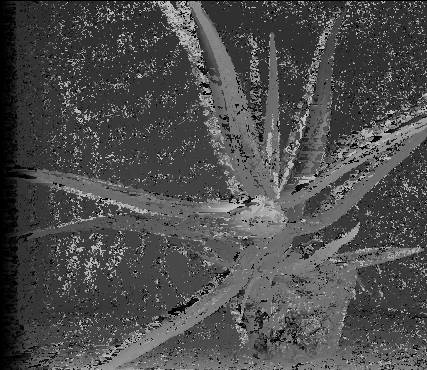

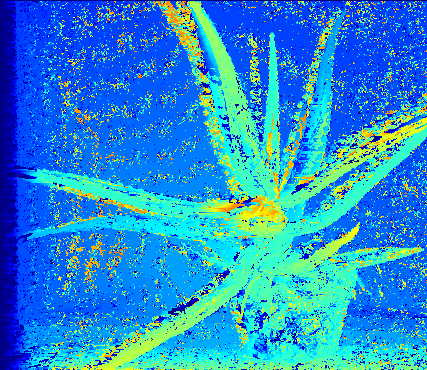

In [ ]:
cv2_imshow(window_based_result_l1)

window_based_l1_color = cv2.imread('window_based_l1_color.png')
cv2_imshow(window_based_l1_color)

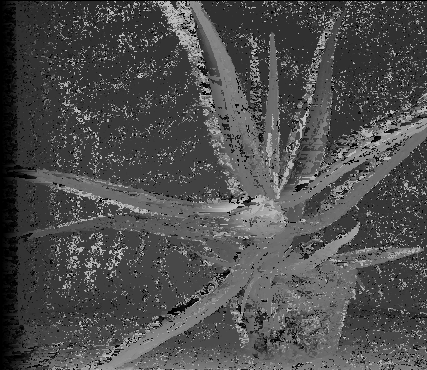

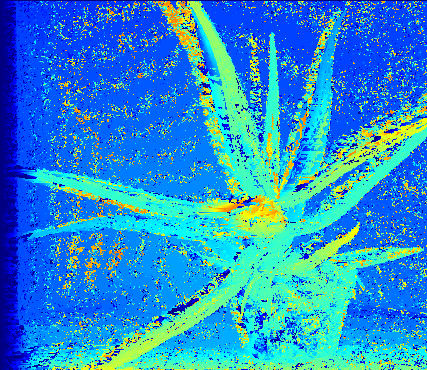

In [ ]:
cv2_imshow(window_based_result_l2)

window_based_l2_color = cv2.imread('window_based_l2_color.png')
cv2_imshow(window_based_l2_color)

#Problem 3

Due to the change of brightness, the disparity map becomes noisy. The L1 and L2 distances cannot work with 2 images with the same features but different brightness because they don’t have ‘invariant to linear changes’ (like cosine similarity).

In [ ]:
left_img_path = '/content/Aloe/Aloe_left_1.png'
right_img_path = '/content/Aloe/Aloe_right_2.png'
disparity_range = 64
kernel_size = 5

window_based_result_l1 = window_based_matching_l1(left_img_path, right_img_path, disparity_range, kernel_size, save_result = True)

window_based_result_l2 = window_based_matching_l2(left_img_path, right_img_path, disparity_range, kernel_size, save_result = True)

Saving result...
Done.
Saving result...
Done.


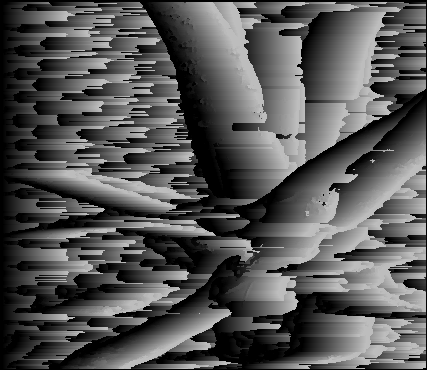

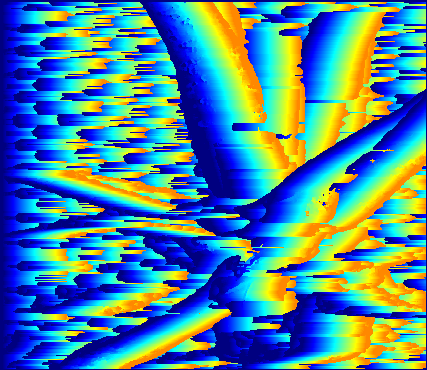

In [ ]:
cv2_imshow(window_based_result_l1)

window_based_l1_color = cv2.imread('window_based_l1_color.png')
cv2_imshow(window_based_l1_color)

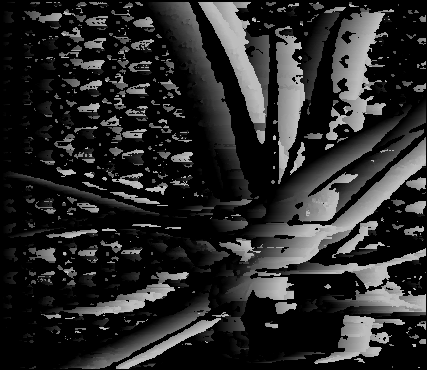

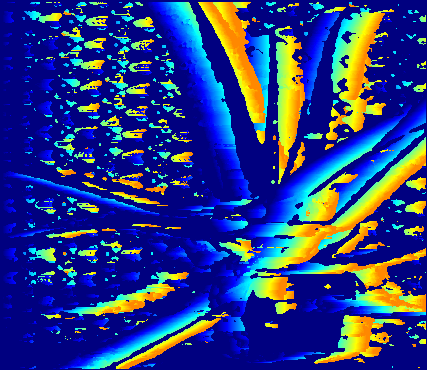

In [ ]:
cv2_imshow(window_based_result_l2)

window_based_l2_color = cv2.imread('window_based_l2_color.png')
cv2_imshow(window_based_l2_color)

#Problem 4

In [ ]:
def cosine_similarity(x, y):
    numerator = np.dot(x, y)
    denominator = np.linalg.norm(x) * np.linalg.norm(y)
    return numerator / denominator

In [ ]:
def window_based_matching_cosine_similarity(left_img, right_img, disparity_range, kernel_size=5, save_result=True):
    # Read left, right images then convert to grayscale
    left = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]

    # Create blank disparity map
    depth = np.zeros((height, width), np.uint8)
    kernel_half = int((kernel_size - 1) / 2)
    scale = 3

    for y in range(kernel_half, height - kernel_half):
        for x in range(kernel_half, width - kernel_half):

            disparity = 0
            cost_optimal = -1

            for j in range(disparity_range):
                d = x - j
                cost = -1
                if (d - kernel_half) > 0:
                    wp = left[(y - kernel_half):(y + kernel_half) + 1, (x - kernel_half):(x + kernel_half) + 1]
                    wqd = right[(y - kernel_half):(y + kernel_half) + 1, (d - kernel_half):(d + kernel_half) + 1]

                    wp_flattened = wp.flatten()
                    wqd_flattened = wqd.flatten()

                    cost = cosine_similarity(wp_flattened, wqd_flattened)

                if cost > cost_optimal:
                    cost_optimal = cost
                    disparity = j

            depth[y, x] = disparity * scale

    if save_result:
        print('Saving result...')
        cv2.imwrite('window_based_cosine_similarity.png', depth)
        cv2.imwrite('window_based_cosine_similarity_color.png', cv2.applyColorMap(depth, cv2.COLORMAP_JET))

    print('Done.')
    return depth

In [ ]:
window_based_matching_cosine_similarity_result = window_based_matching_cosine_similarity(left_img_path, right_img_path, disparity_range, kernel_size, save_result = True)

Saving result...
Done.


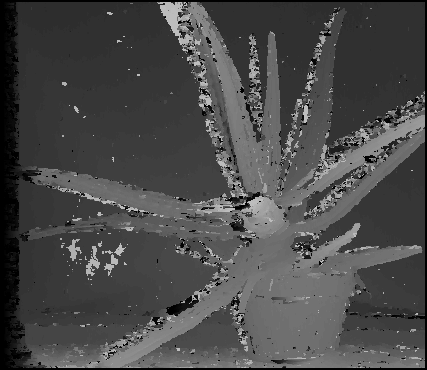

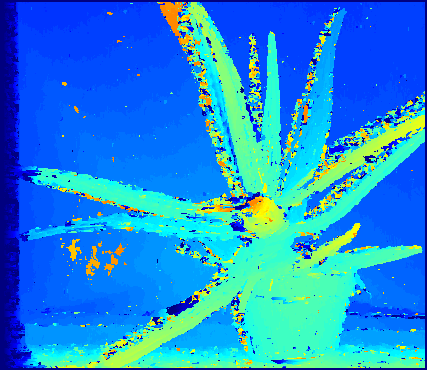

In [ ]:
cv2_imshow(window_based_matching_cosine_similarity_result)

window_based_cosine_similarity_color = cv2.imread('window_based_cosine_similarity_color.png')
cv2_imshow(window_based_cosine_similarity_color)